# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.optim
import torchvision.models as models
import torchvision.transforms as transforms
import warnings
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms.functional import InterpolationMode
from torch.nn.parallel import DataParallel
from tqdm import tqdm

warnings.filterwarnings("ignore")
device = torch.device("cuda")
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    parallel = True
else:
    parallel = False

# EDA

## Damage Severity

In [65]:
train_path = 'C:/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_train_final.tsv'
test_path = 'C:/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_test_final.tsv'
dev_path = 'C:/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_dev_final.tsv'

train_label = pd.read_table(train_path)
test_label = pd.read_table(test_path)
dev_label = pd.read_table(dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(28319, 4)
(3865, 4)
(2712, 4)


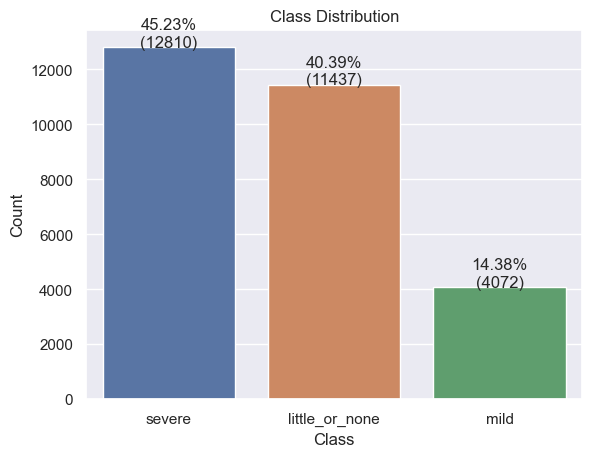

In [66]:
# severe 嚴重; little_or_none 輕微或無; mild 中等
class_count = train_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(train_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(train_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

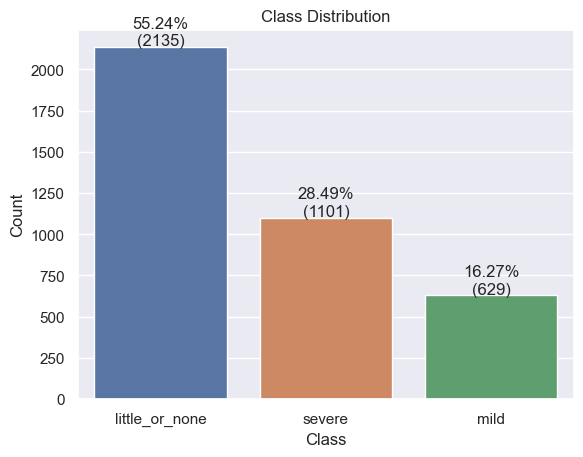

In [67]:
# severe 嚴重; little_or_none 輕微或無; mild 中等
class_count = test_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(test_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(test_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

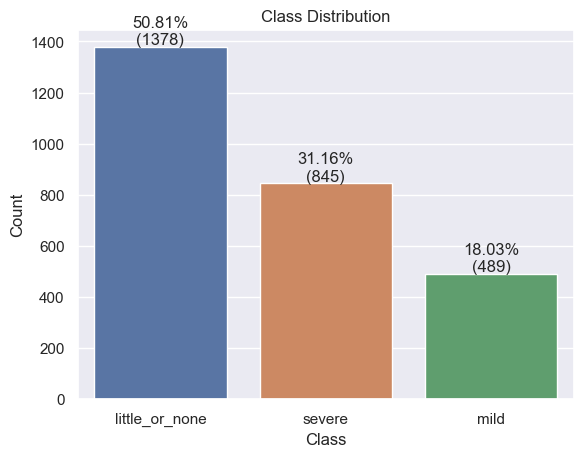

In [68]:
# severe 嚴重; little_or_none 輕微或無; mild 中等
class_count = dev_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(dev_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(dev_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

## Disaster Types

In [69]:
dt_train_path = 'C:/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_train_final.tsv'
dt_test_path = 'C:/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_test_final.tsv'
dt_dev_path = 'C:/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_dev_final.tsv'

train_label = pd.read_table(dt_train_path)
test_label = pd.read_table(dt_test_path)
dev_label = pd.read_table(dt_dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(12846, 4)
(3195, 4)
(1470, 4)


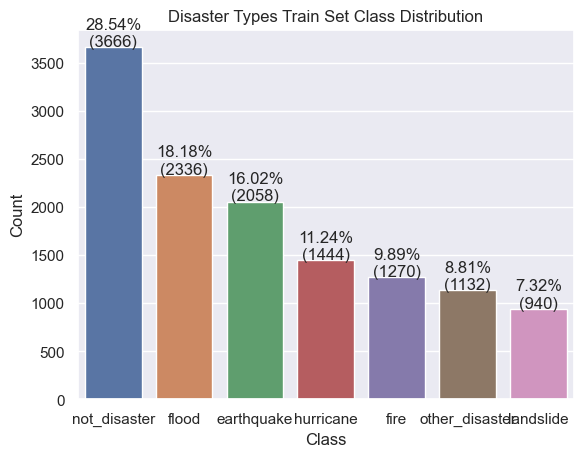

In [70]:
# not_disaster; flood; earthquake; hurricane; fire; other_disaster; landslide
class_count = train_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(train_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Disaster Types Train Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(train_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

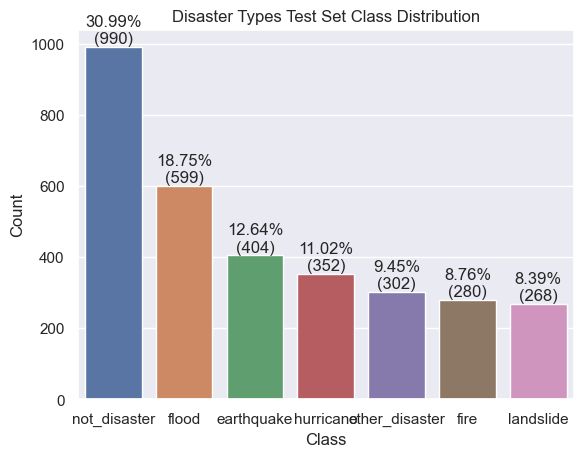

In [71]:
# not_disaster; flood; earthquake; hurricane; fire; other_disaster; landslide
class_count = test_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(test_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Disaster Types Test Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(test_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

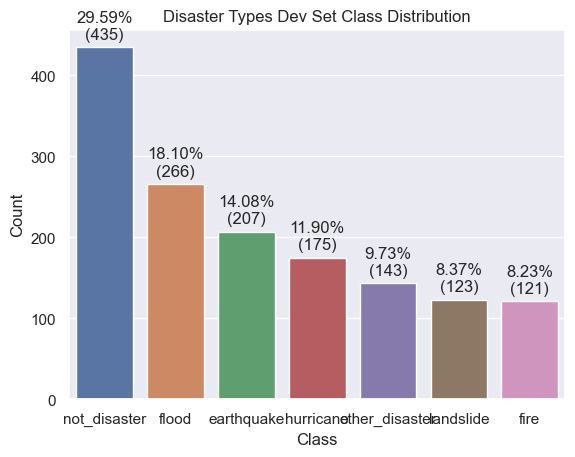

In [72]:
# not_disaster; flood; earthquake; hurricane; fire; other_disaster; landslide
class_count = dev_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(dev_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Disaster Types Dev Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(dev_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

## Humanitarian

In [73]:
hm_train_path = 'C:/crisis_vision_benchmarks/tasks/humanitarian/consolidated/consolidated_hum_train_final.tsv'
hm_test_path = 'C:/crisis_vision_benchmarks/tasks/humanitarian/consolidated/consolidated_hum_test_final.tsv'
hm_dev_path = 'C:/crisis_vision_benchmarks/tasks/humanitarian/consolidated/consolidated_hum_dev_final.tsv'

train_label = pd.read_table(hm_train_path)
test_label = pd.read_table(hm_test_path)
dev_label = pd.read_table(hm_dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(12618, 4)
(2922, 4)
(1229, 4)


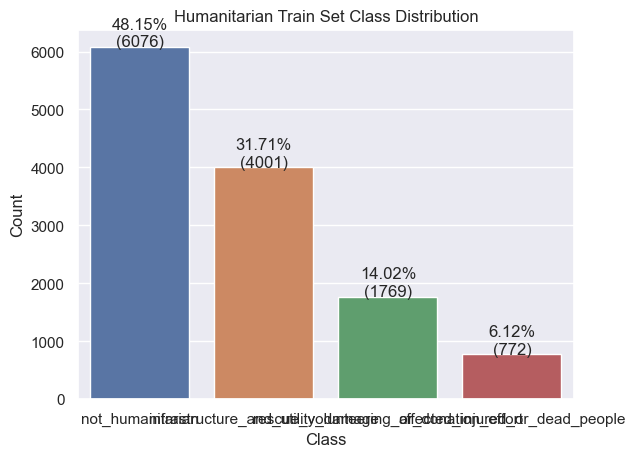

In [74]:
# not_humanitarian; infrastructure_and_utility_damage; rescue_volunteering_or_donation_effort; affected_injured_or_dead_people
class_count = train_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(train_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Humanitarian Train Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(train_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

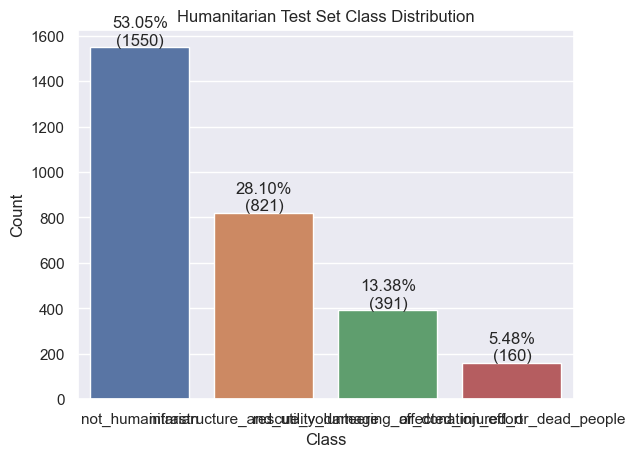

In [75]:
# not_humanitarian; infrastructure_and_utility_damage; rescue_volunteering_or_donation_effort; affected_injured_or_dead_people
class_count = test_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(test_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Humanitarian Test Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(test_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

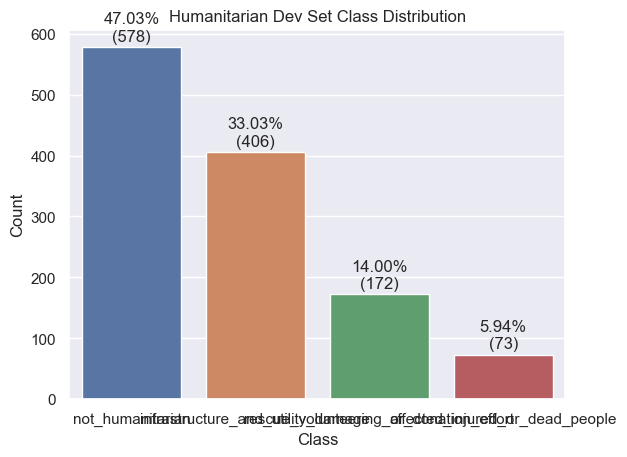

In [76]:
# not_humanitarian; infrastructure_and_utility_damage; rescue_volunteering_or_donation_effort; affected_injured_or_dead_people
class_count = dev_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(dev_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Humanitarian Dev Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(dev_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

## Informativeness

In [77]:
if_train_path = 'C:/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_train_final.tsv'
if_test_path = 'C:/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_test_final.tsv'
if_dev_path = 'C:/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_dev_final.tsv'

train_label = pd.read_table(if_train_path)
test_label = pd.read_table(if_test_path)
dev_label = pd.read_table(if_dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(48186, 4)
(8477, 4)
(3054, 4)


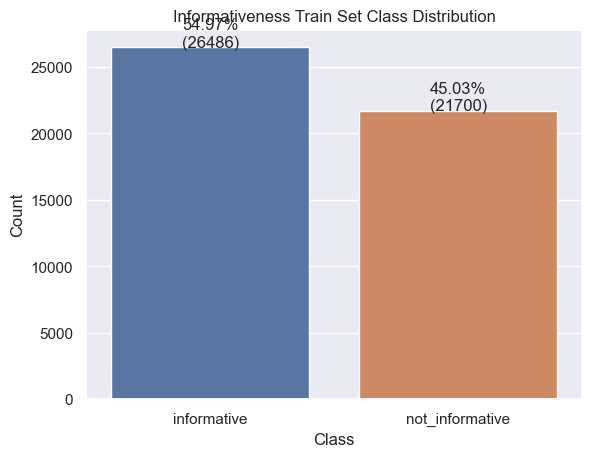

In [78]:
# informative; not informative
class_count = train_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(train_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Informativeness Train Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(train_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

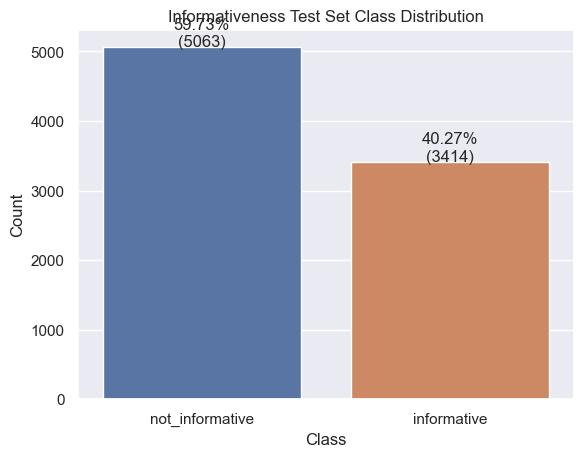

In [79]:
# informative; not informative
class_count = test_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(test_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Informativeness Test Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(test_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

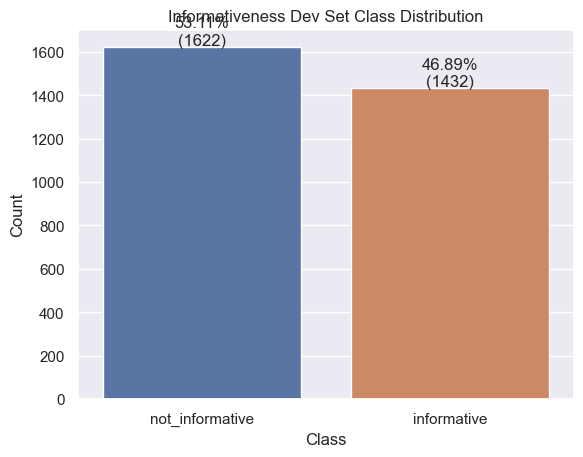

In [80]:
# informative; not informative
class_count = dev_label['class_label'].value_counts()

# for class_name, count in class_count.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(dev_label) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
ax = sns.barplot(x=class_count.index, y=class_count.values)
ax.set_title("Informativeness Dev Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(dev_label))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

# Disaster Types + Damage Severity

In [81]:
ds_train_path = 'C:/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_train_final.tsv'
ds_test_path = 'C:/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_test_final.tsv'
ds_dev_path = 'C:/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_dev_final.tsv'

dt_train_path = 'C:/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_train_final.tsv'
dt_test_path = 'C:/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_test_final.tsv'
dt_dev_path = 'C:/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_dev_final.tsv'

ds_train_label = pd.read_table(ds_train_path)
ds_test_label = pd.read_table(ds_test_path)
ds_dev_label = pd.read_table(ds_dev_path)

dt_train_label = pd.read_table(dt_train_path)
dt_test_label = pd.read_table(dt_test_path)
dt_dev_label = pd.read_table(dt_dev_path)

print('Disaster Types:')
print(dt_train_label.shape)
print(dt_test_label.shape)
print(dt_dev_label.shape)

print()

print('Damage Severity:')
print(ds_train_label.shape)
print(ds_test_label.shape)
print(ds_dev_label.shape)

Disaster Types:
(12846, 4)
(3195, 4)
(1470, 4)

Damage Severity:
(28319, 4)
(3865, 4)
(2712, 4)


In [82]:
merged_train = pd.merge(dt_train_label, ds_train_label, on='image_path')
merged_test = pd.merge(dt_test_label, ds_test_label, on='image_path')
merged_dev = pd.merge(dt_dev_label, ds_dev_label, on='image_path')

merged_train = merged_train.drop(['event_name_x', 'event_name_y', 'image_id_y'], axis=1)
merged_test = merged_test.drop(['event_name_x', 'event_name_y', 'image_id_y'], axis=1)
merged_dev = merged_dev.drop(['event_name_x', 'event_name_y', 'image_id_y'], axis=1)

merged_train = merged_train.rename(columns={'image_id_x': 'image_id', 'class_label_x': 'class_label_disaster_types', 'class_label_y': 'class_label_damage_severity'})
merged_test = merged_test.rename(columns={'image_id_x': 'image_id', 'class_label_x': 'class_label_disaster_types', 'class_label_y': 'class_label_damage_severity'})
merged_dev = merged_dev.rename(columns={'image_id_x': 'image_id', 'class_label_x': 'class_label_disaster_types', 'class_label_y': 'class_label_damage_severity'})

merged_train = merged_train.sort_values(by='class_label_disaster_types', ascending=True)
merged_test = merged_test.sort_values(by='class_label_disaster_types', ascending=True)
merged_dev = merged_dev.sort_values(by='class_label_disaster_types', ascending=True)

print(merged_train.shape)
print(merged_test.shape)
print(merged_dev.shape)

(3061, 4)
(217, 4)
(51, 4)


## Class Count

### Train Set

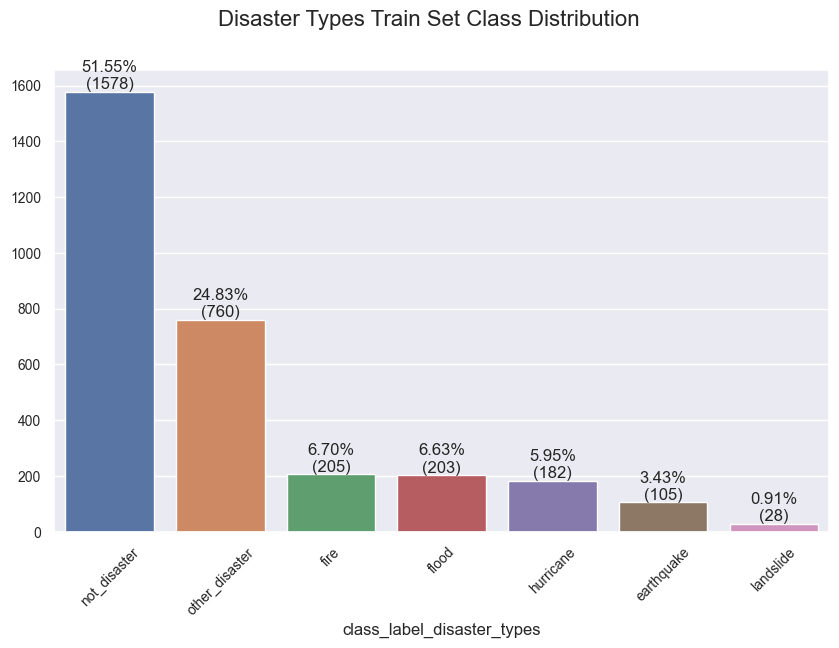

In [83]:
class_count_train = merged_train['class_label_disaster_types'].value_counts()
class_count_test = merged_test['class_label_disaster_types'].value_counts()
class_count_dev = merged_dev['class_label_disaster_types'].value_counts()

# print('Train Set Class Count:')
# for class_name, count in class_count_train.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(merged_train) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax.set_title("Disaster Types Train Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.suptitle("Disaster Types Train Set Class Distribution", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=45)
ax = sns.barplot(x=class_count_train.index, y=class_count_train.values)

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(merged_train))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 10
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

### Test Set

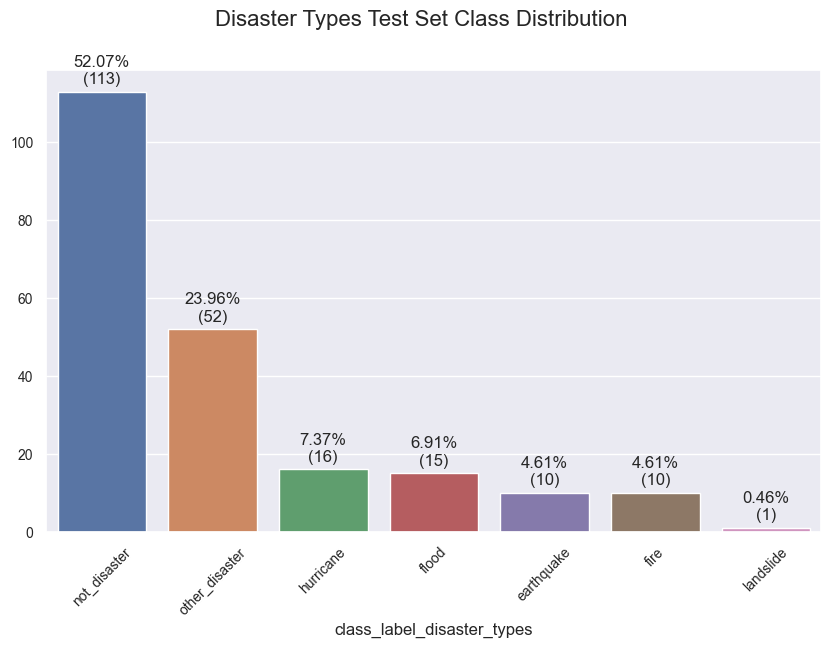

In [84]:
# print('Test Set Class Count:')
# for class_name, count in class_count_test.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(merged_test) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax.set_title("Disaster Types Test Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.suptitle("Disaster Types Test Set Class Distribution", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=45)
ax = sns.barplot(x=class_count_test.index, y=class_count_test.values)

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(merged_test))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 2
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

plt.show()

### Dev Set

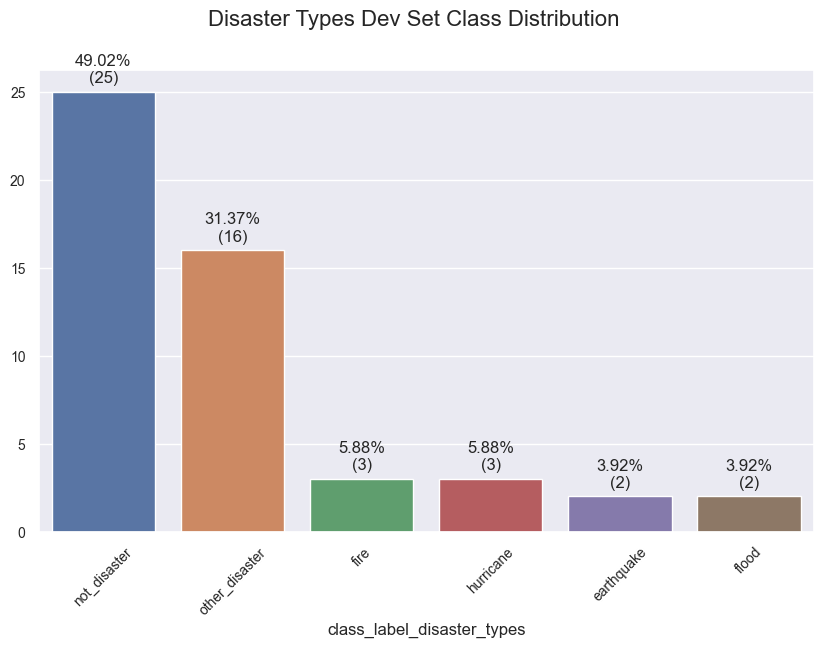

In [85]:
# print('Dev Set Class Count:')
# for class_name, count in class_count_dev.items():
#     print("Class:", class_name)
#     print("Count:", count)
#     print("Percentage: {:.2f}%".format(count / len(merged_dev) * 100))
#     print()

# Visualization
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax.set_title("Disaster Types Dev Set Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.suptitle("Disaster Types Dev Set Class Distribution", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=45)
ax = sns.barplot(x=class_count_dev.index, y=class_count_dev.values)

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / len(merged_dev))
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.5
    ax.annotate(f'{percentage}\n({count})', (x, y), ha='center')

## Group csv

In [89]:
output_folder = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types'

grouped_train = merged_train.groupby('class_label_disaster_types')
grouped_test = merged_test.groupby('class_label_disaster_types')
grouped_dev = merged_dev.groupby('class_label_disaster_types')

for group_name, group_data in grouped_train:
    file_path = os.path.join(output_folder, f'class_{group_name}_train.csv')
    group_data.to_csv(file_path, index=False)

for group_name, group_data in grouped_test:
    file_path = os.path.join(output_folder, f'class_{group_name}_test.csv')
    group_data.to_csv(file_path, index=False)

for group_name, group_data in grouped_dev:
    file_path = os.path.join(output_folder, f'class_{group_name}_dev.csv')
    group_data.to_csv(file_path, index=False)

## Earthquake

### Data Loading

In [2]:
# Earthquake
train_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_earthquake_train.csv'
test_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_earthquake_test.csv'
dev_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_earthquake_dev.csv'

train_label = pd.read_csv(train_path)
test_label = pd.read_csv(test_path)
dev_label = pd.read_csv(dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(105, 4)
(10, 4)
(2, 4)


In [3]:
class_label_map = {"severe": 2, "mild": 1, "little_or_none": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label_damage_severity']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('C:/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.convert("RGB")
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

100%|██████████| 105/105 [00:01<00:00, 72.76it/s]


torch.Size([3, 256, 256])
(105, 3, 256, 256)


100%|██████████| 105/105 [00:00<?, ?it/s]


(105,)


100%|██████████| 10/10 [00:00<00:00, 59.17it/s]


torch.Size([3, 256, 256])
(10, 3, 256, 256)


100%|██████████| 10/10 [00:00<?, ?it/s]


(10,)


100%|██████████| 2/2 [00:00<00:00, 64.53it/s]


torch.Size([3, 256, 256])
(2, 3, 256, 256)


100%|██████████| 2/2 [00:00<?, ?it/s]

(2,)


In [4]:
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)

print("Number of unique classes:", num_classes)
print("Unique classes:", unique_classes)

Number of unique classes: 3
Unique classes: [0 1 2]


In [5]:
batch_size = 64

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

### EfficientNet

In [6]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

In [7]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "earthquake_severity_eff.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [8]:
best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.1041 - accuracy: 32.38% - val_loss: 1.0905 - val_accuracy: 50.00% - time: 8.60s
Epoch 2/100 - loss: 1.1003 - accuracy: 31.43% - val_loss: 1.0902 - val_accuracy: 50.00% - time: 4.87s
Epoch 3/100 - loss: 1.0986 - accuracy: 37.14% - val_loss: 1.0874 - val_accuracy: 50.00% - time: 4.94s
Epoch 4/100 - loss: 1.0998 - accuracy: 32.38% - val_loss: 1.0835 - val_accuracy: 50.00% - time: 5.07s
Epoch 5/100 - loss: 1.1033 - accuracy: 38.10% - val_loss: 1.0792 - val_accuracy: 50.00% - time: 4.87s
Epoch 6/100 - loss: 1.0849 - accuracy: 43.81% - val_loss: 1.0755 - val_accuracy: 40.00% - time: 4.87s
Epoch 7/100 - loss: 1.0847 - accuracy: 41.90% - val_loss: 1.0727 - val_accuracy: 40.00% - time: 4.88s
Epoch 8/100 - loss: 1.0774 - accuracy: 48.57% - val_loss: 1.0718 - val_accuracy: 40.00% - time: 4.99s
Epoch 9/100 - loss: 1.0705 - accuracy: 47.62% - val_loss: 1.0724 - val_accuracy: 40.00% - time: 4.95s
Epoch 10/100 - loss: 1.0756 - accuracy: 47.62% - val_loss: 1.0711 - val_accuracy: 

In [9]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 70.00%
F1-Score : 61.43%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.50      0.50         2
           2       0.75      1.00      0.86         6

    accuracy                           0.70        10
   macro avg       0.42      0.50      0.45        10
weighted avg       0.55      0.70      0.61        10



#### Visualize

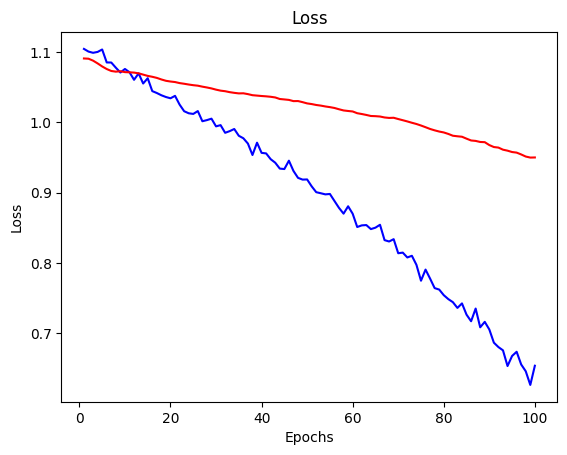

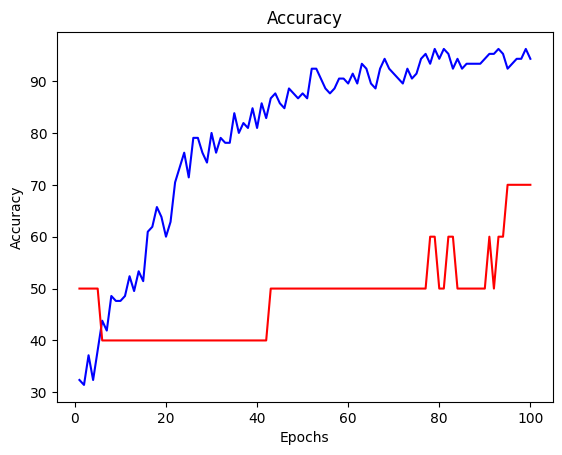

In [10]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


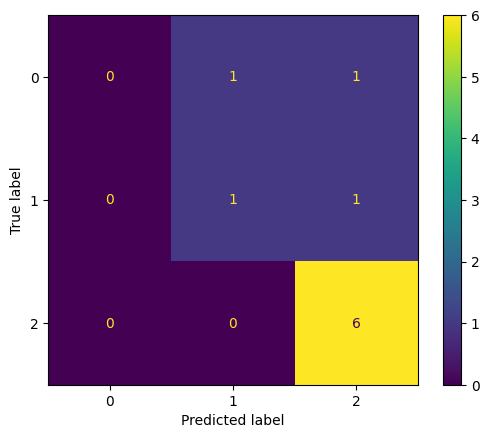

In [11]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

### ResNet50

In [12]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

In [13]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "earthquake_severity_res.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [14]:
best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.1246 - accuracy: 25.71% - val_loss: 1.1412 - val_accuracy: 30.00% - time: 5.01s
Epoch 2/100 - loss: 1.0857 - accuracy: 39.05% - val_loss: 1.1277 - val_accuracy: 30.00% - time: 4.74s
Epoch 3/100 - loss: 1.0482 - accuracy: 52.38% - val_loss: 1.1060 - val_accuracy: 40.00% - time: 4.73s
Epoch 4/100 - loss: 1.0229 - accuracy: 61.90% - val_loss: 1.0873 - val_accuracy: 40.00% - time: 4.96s
Epoch 5/100 - loss: 0.9850 - accuracy: 75.24% - val_loss: 1.0735 - val_accuracy: 60.00% - time: 5.54s
Epoch 6/100 - loss: 0.9578 - accuracy: 83.81% - val_loss: 1.0665 - val_accuracy: 60.00% - time: 4.69s
Epoch 7/100 - loss: 0.9195 - accuracy: 91.43% - val_loss: 1.0595 - val_accuracy: 40.00% - time: 4.57s
Epoch 8/100 - loss: 0.8924 - accuracy: 97.14% - val_loss: 1.0487 - val_accuracy: 40.00% - time: 4.49s
Epoch 9/100 - loss: 0.8739 - accuracy: 95.24% - val_loss: 1.0334 - val_accuracy: 40.00% - time: 4.51s
Epoch 10/100 - loss: 0.8380 - accuracy: 98.10% - val_loss: 1.0206 - val_accuracy: 

In [15]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 60.00%
F1-Score : 60.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.25      0.50      0.33         2
           2       0.67      0.67      0.67         6

    accuracy                           0.50        10
   macro avg       0.31      0.39      0.33        10
weighted avg       0.45      0.50      0.47        10



#### Visualize

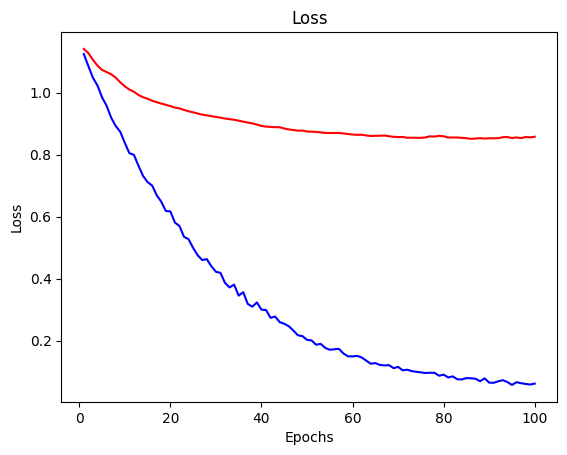

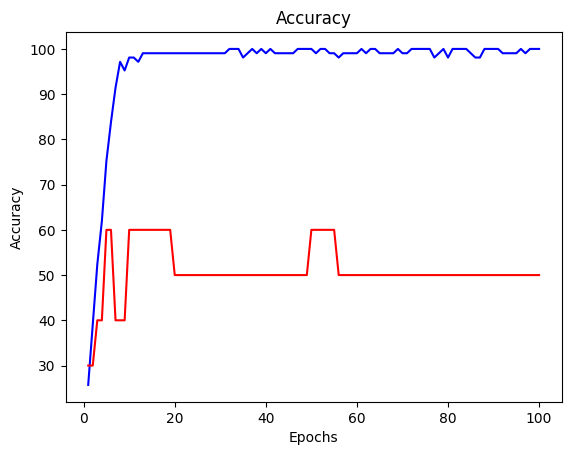

In [16]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


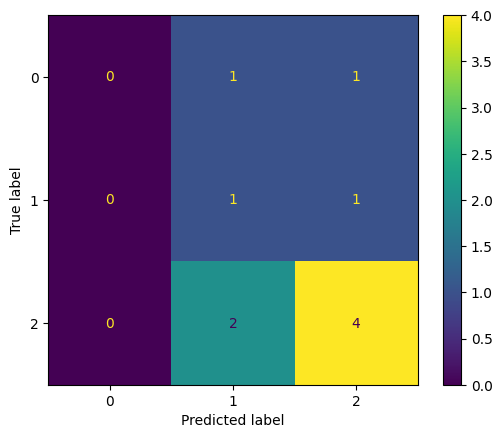

In [17]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

## Fire

### Data Loading

In [2]:
# Fire
train_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_fire_train.csv'
test_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_fire_test.csv'
dev_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_fire_dev.csv'

train_label = pd.read_csv(train_path)
test_label = pd.read_csv(test_path)
dev_label = pd.read_csv(dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(205, 4)
(10, 4)
(3, 4)


In [3]:
class_label_map = {"severe": 2, "mild": 1, "little_or_none": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label_damage_severity']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('C:/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.convert("RGB")
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

100%|██████████| 205/205 [00:02<00:00, 81.80it/s]


torch.Size([3, 256, 256])
(205, 3, 256, 256)


100%|██████████| 205/205 [00:00<?, ?it/s]


(205,)


100%|██████████| 10/10 [00:00<00:00, 103.09it/s]


torch.Size([3, 256, 256])
(10, 3, 256, 256)


100%|██████████| 10/10 [00:00<?, ?it/s]


(10,)


100%|██████████| 3/3 [00:00<00:00, 124.98it/s]


torch.Size([3, 256, 256])
(3, 3, 256, 256)


100%|██████████| 3/3 [00:00<?, ?it/s]

(3,)


In [4]:
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)

print("Number of unique classes:", num_classes)
print("Unique classes:", unique_classes)

Number of unique classes: 3
Unique classes: [0 1 2]


In [5]:
batch_size = 64

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

### EfficientNet

In [6]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "fire_severity_eff.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.0942 - accuracy: 32.68% - val_loss: 1.1150 - val_accuracy: 20.00% - time: 8.89s
Epoch 2/100 - loss: 1.0874 - accuracy: 41.95% - val_loss: 1.1012 - val_accuracy: 40.00% - time: 6.12s
Epoch 3/100 - loss: 1.0775 - accuracy: 43.90% - val_loss: 1.0990 - val_accuracy: 40.00% - time: 5.74s
Epoch 4/100 - loss: 1.0750 - accuracy: 51.71% - val_loss: 1.0939 - val_accuracy: 30.00% - time: 5.63s
Epoch 5/100 - loss: 1.0656 - accuracy: 53.17% - val_loss: 1.0841 - val_accuracy: 30.00% - time: 5.56s
Epoch 6/100 - loss: 1.0546 - accuracy: 55.61% - val_loss: 1.0738 - val_accuracy: 30.00% - time: 5.76s
Epoch 7/100 - loss: 1.0442 - accuracy: 60.00% - val_loss: 1.0674 - val_accuracy: 40.00% - time: 5.49s
Epoch 8/100 - loss: 1.0493 - accuracy: 54.15% - val_loss: 1.0590 - val_accuracy: 60.00% - time: 5.59s
Epoch 9/100 - loss: 1.0369 - accuracy: 60.98% - val_loss: 1.0517 - val_accuracy: 60.00% - time: 5.46s
Epoch 10/100 - loss: 1.0359 - accuracy: 65.85% - val_loss: 1.0486 - val_accuracy: 

In [7]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 90.00%
F1-Score : 85.26%
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.89      0.89      0.89         9

    accuracy                           0.80        10
   macro avg       0.44      0.44      0.44        10
weighted avg       0.80      0.80      0.80        10



#### Visualize

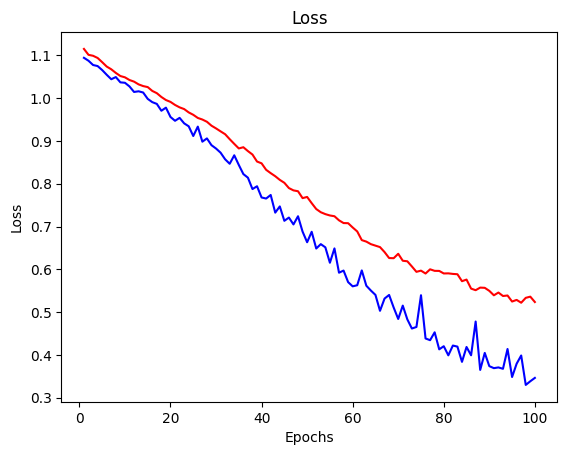

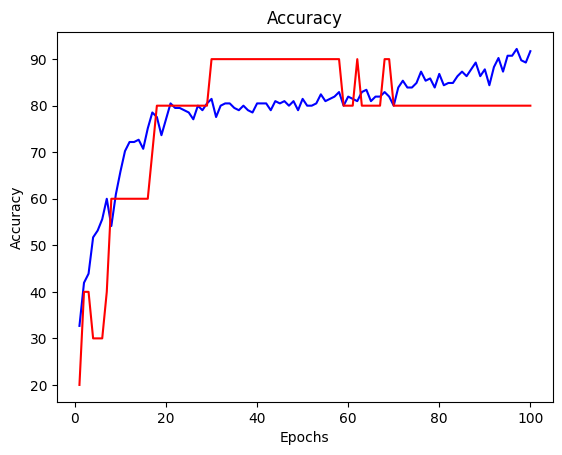

In [8]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


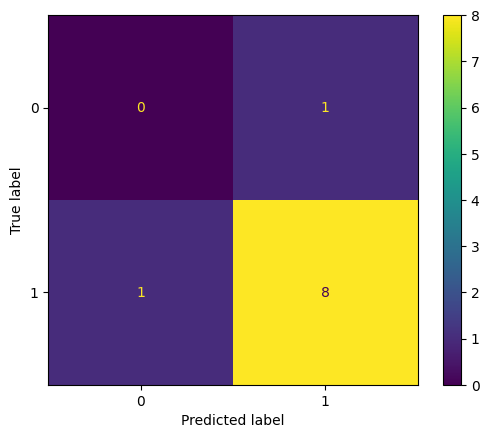

In [9]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

### ResNet50

In [10]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "fire_severity_res.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.1307 - accuracy: 23.90% - val_loss: 1.2637 - val_accuracy: 10.00% - time: 6.07s
Epoch 2/100 - loss: 1.0358 - accuracy: 42.44% - val_loss: 1.2052 - val_accuracy: 10.00% - time: 5.59s
Epoch 3/100 - loss: 0.9593 - accuracy: 61.95% - val_loss: 1.1309 - val_accuracy: 20.00% - time: 5.62s
Epoch 4/100 - loss: 0.8782 - accuracy: 75.12% - val_loss: 1.0755 - val_accuracy: 40.00% - time: 5.38s
Epoch 5/100 - loss: 0.8001 - accuracy: 83.41% - val_loss: 1.0232 - val_accuracy: 50.00% - time: 5.63s
Epoch 6/100 - loss: 0.7404 - accuracy: 91.22% - val_loss: 0.9696 - val_accuracy: 50.00% - time: 5.70s
Epoch 7/100 - loss: 0.6884 - accuracy: 95.12% - val_loss: 0.9367 - val_accuracy: 50.00% - time: 5.55s
Epoch 8/100 - loss: 0.5929 - accuracy: 98.05% - val_loss: 0.8914 - val_accuracy: 60.00% - time: 5.45s
Epoch 9/100 - loss: 0.5326 - accuracy: 98.54% - val_loss: 0.8515 - val_accuracy: 60.00% - time: 5.44s
Epoch 10/100 - loss: 0.4691 - accuracy: 99.02% - val_loss: 0.8041 - val_accuracy: 

In [11]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 90.00%
F1-Score : 90.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       1.00      0.89      0.94         9

    accuracy                           0.80        10
   macro avg       0.33      0.30      0.31        10
weighted avg       0.90      0.80      0.85        10



#### Visualize

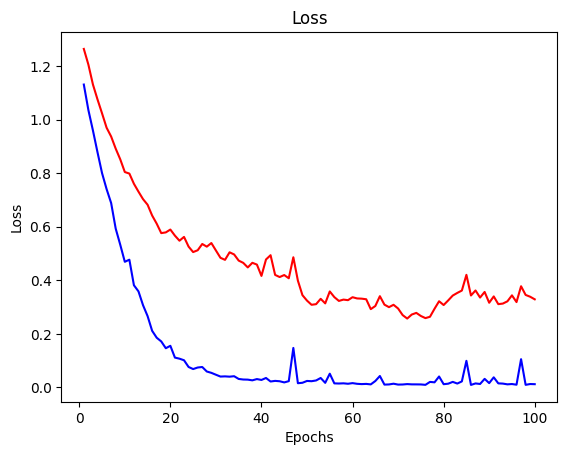

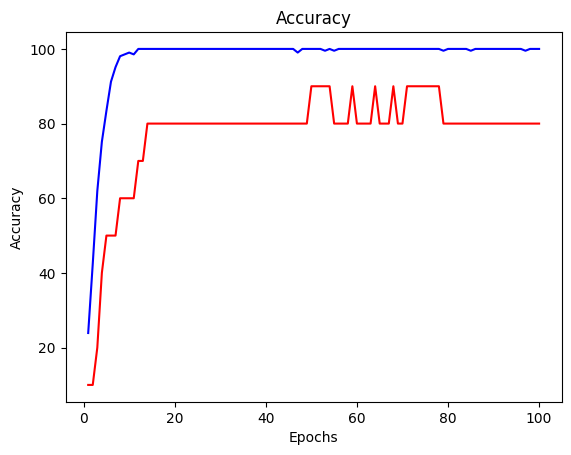

In [12]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


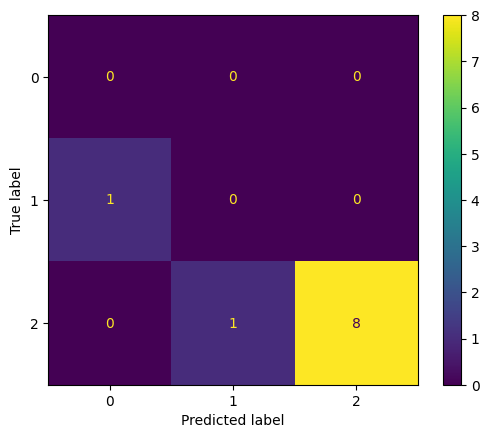

In [13]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

## Flood

### Data Loading

In [14]:
# Flood
train_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_flood_train.csv'
test_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_flood_test.csv'
dev_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_flood_dev.csv'

train_label = pd.read_csv(train_path)
test_label = pd.read_csv(test_path)
dev_label = pd.read_csv(dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(203, 4)
(15, 4)
(2, 4)


In [15]:
class_label_map = {"severe": 2, "mild": 1, "little_or_none": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label_damage_severity']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('C:/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.convert("RGB")
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

100%|██████████| 203/203 [00:02<00:00, 81.74it/s]


torch.Size([3, 256, 256])
(203, 3, 256, 256)


100%|██████████| 203/203 [00:00<?, ?it/s]


(203,)


100%|██████████| 15/15 [00:00<00:00, 77.72it/s]


torch.Size([3, 256, 256])
(15, 3, 256, 256)


100%|██████████| 15/15 [00:00<?, ?it/s]


(15,)


100%|██████████| 2/2 [00:00<00:00, 142.86it/s]


torch.Size([3, 256, 256])
(2, 3, 256, 256)


100%|██████████| 2/2 [00:00<?, ?it/s]

(2,)


In [16]:
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)

print("Number of unique classes:", num_classes)
print("Unique classes:", unique_classes)

Number of unique classes: 3
Unique classes: [0 1 2]


In [17]:
batch_size = 64

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

### EfficientNet

In [18]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "flood_severity_eff.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.1191 - accuracy: 29.06% - val_loss: 1.1172 - val_accuracy: 33.33% - time: 5.37s
Epoch 2/100 - loss: 1.1082 - accuracy: 30.54% - val_loss: 1.1083 - val_accuracy: 33.33% - time: 5.28s
Epoch 3/100 - loss: 1.1082 - accuracy: 32.02% - val_loss: 1.1013 - val_accuracy: 20.00% - time: 5.10s
Epoch 4/100 - loss: 1.1011 - accuracy: 34.48% - val_loss: 1.0988 - val_accuracy: 26.67% - time: 5.18s
Epoch 5/100 - loss: 1.1058 - accuracy: 38.92% - val_loss: 1.0967 - val_accuracy: 26.67% - time: 5.21s
Epoch 6/100 - loss: 1.0875 - accuracy: 36.95% - val_loss: 1.0950 - val_accuracy: 26.67% - time: 5.22s
Epoch 7/100 - loss: 1.0893 - accuracy: 45.81% - val_loss: 1.0931 - val_accuracy: 40.00% - time: 5.17s
Epoch 8/100 - loss: 1.0900 - accuracy: 40.39% - val_loss: 1.0888 - val_accuracy: 40.00% - time: 5.36s
Epoch 9/100 - loss: 1.0811 - accuracy: 46.31% - val_loss: 1.0838 - val_accuracy: 40.00% - time: 5.24s
Epoch 10/100 - loss: 1.0764 - accuracy: 45.81% - val_loss: 1.0806 - val_accuracy: 

In [19]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 86.67%
F1-Score : 80.48%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           2       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.43      0.46      0.44        15
weighted avg       0.74      0.80      0.77        15



#### Visualize

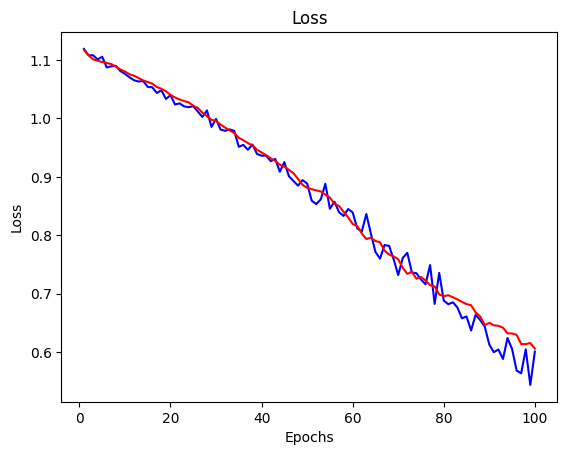

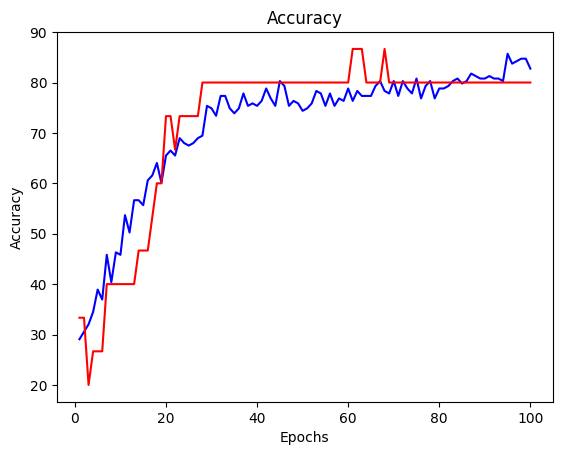

In [20]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


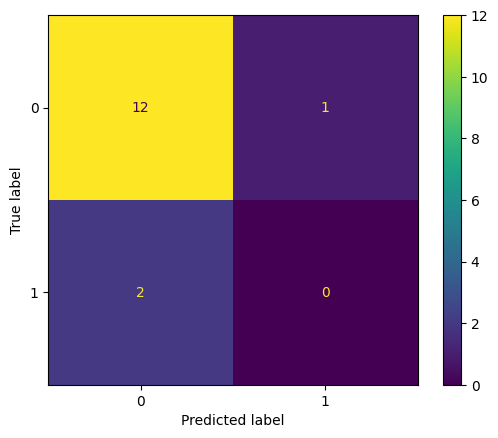

In [21]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

### ResNet50

In [22]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "flood_severity_res.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.1810 - accuracy: 24.14% - val_loss: 1.0405 - val_accuracy: 40.00% - time: 5.64s
Epoch 2/100 - loss: 1.0498 - accuracy: 42.86% - val_loss: 0.9599 - val_accuracy: 73.33% - time: 5.53s
Epoch 3/100 - loss: 0.9603 - accuracy: 64.04% - val_loss: 0.9092 - val_accuracy: 80.00% - time: 5.54s
Epoch 4/100 - loss: 0.8715 - accuracy: 81.28% - val_loss: 0.8670 - val_accuracy: 93.33% - time: 5.45s
Epoch 5/100 - loss: 0.7978 - accuracy: 89.66% - val_loss: 0.8295 - val_accuracy: 93.33% - time: 5.39s
Epoch 6/100 - loss: 0.7451 - accuracy: 93.60% - val_loss: 0.7929 - val_accuracy: 93.33% - time: 5.50s
Epoch 7/100 - loss: 0.7046 - accuracy: 94.58% - val_loss: 0.7551 - val_accuracy: 93.33% - time: 5.57s
Epoch 8/100 - loss: 0.6286 - accuracy: 97.54% - val_loss: 0.7266 - val_accuracy: 93.33% - time: 5.45s
Epoch 9/100 - loss: 0.5704 - accuracy: 98.52% - val_loss: 0.6986 - val_accuracy: 86.67% - time: 5.43s
Epoch 10/100 - loss: 0.5500 - accuracy: 96.55% - val_loss: 0.6679 - val_accuracy: 

In [23]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 93.33%
F1-Score : 96.53%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.00      0.00      0.00         0
           2       1.00      0.50      0.67         2

    accuracy                           0.87        15
   macro avg       0.67      0.47      0.54        15
weighted avg       1.00      0.87      0.92        15



#### Visualization

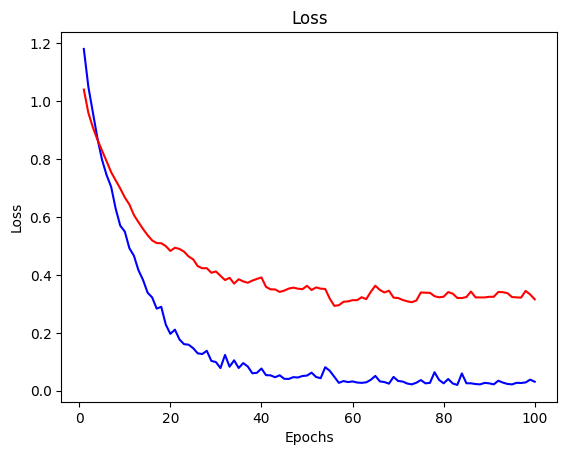

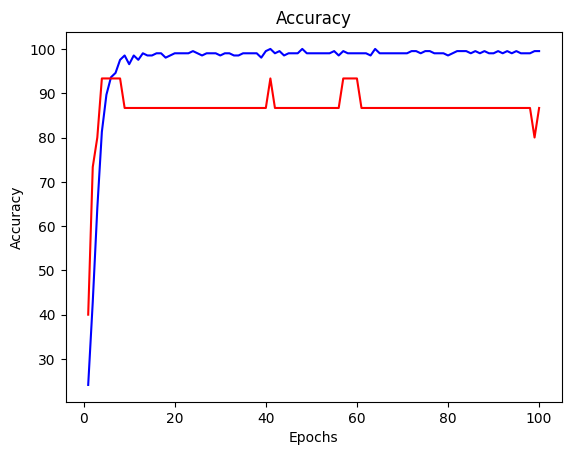

In [24]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


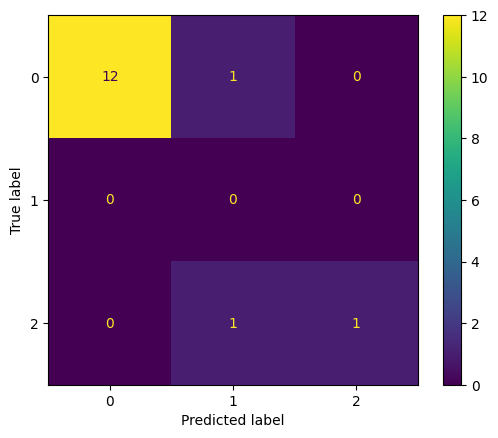

In [25]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

## Hurricane

### Data Loading

In [26]:
# Hurricane
train_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_hurricane_train.csv'
test_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_hurricane_test.csv'
dev_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_hurricane_dev.csv'

train_label = pd.read_csv(train_path)
test_label = pd.read_csv(test_path)
dev_label = pd.read_csv(dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(182, 4)
(16, 4)
(3, 4)


In [27]:
class_label_map = {"severe": 2, "mild": 1, "little_or_none": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label_damage_severity']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('C:/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.convert("RGB")
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

100%|██████████| 182/182 [00:02<00:00, 67.81it/s]


torch.Size([3, 256, 256])
(182, 3, 256, 256)


100%|██████████| 182/182 [00:00<00:00, 181839.76it/s]


(182,)


100%|██████████| 16/16 [00:00<00:00, 83.33it/s]


torch.Size([3, 256, 256])
(16, 3, 256, 256)


100%|██████████| 16/16 [00:00<?, ?it/s]


(16,)


100%|██████████| 3/3 [00:00<00:00, 125.00it/s]


torch.Size([3, 256, 256])
(3, 3, 256, 256)


100%|██████████| 3/3 [00:00<?, ?it/s]

(3,)


In [28]:
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)

print("Number of unique classes:", num_classes)
print("Unique classes:", unique_classes)

Number of unique classes: 3
Unique classes: [0 1 2]


In [29]:
batch_size = 64

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

### EfficientNet

In [30]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "hurricane_severity_eff.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.0974 - accuracy: 34.07% - val_loss: 1.1029 - val_accuracy: 31.25% - time: 5.25s
Epoch 2/100 - loss: 1.0981 - accuracy: 35.71% - val_loss: 1.0977 - val_accuracy: 25.00% - time: 5.15s
Epoch 3/100 - loss: 1.0856 - accuracy: 39.56% - val_loss: 1.0948 - val_accuracy: 25.00% - time: 5.28s
Epoch 4/100 - loss: 1.0823 - accuracy: 46.15% - val_loss: 1.0924 - val_accuracy: 37.50% - time: 5.27s
Epoch 5/100 - loss: 1.0842 - accuracy: 41.76% - val_loss: 1.0916 - val_accuracy: 37.50% - time: 5.01s
Epoch 6/100 - loss: 1.0860 - accuracy: 44.51% - val_loss: 1.0921 - val_accuracy: 31.25% - time: 5.30s
Epoch 7/100 - loss: 1.0758 - accuracy: 48.35% - val_loss: 1.0922 - val_accuracy: 31.25% - time: 5.22s
Epoch 8/100 - loss: 1.0660 - accuracy: 52.75% - val_loss: 1.0912 - val_accuracy: 31.25% - time: 5.19s
Epoch 9/100 - loss: 1.0646 - accuracy: 48.35% - val_loss: 1.0893 - val_accuracy: 43.75% - time: 5.42s
Epoch 10/100 - loss: 1.0658 - accuracy: 55.49% - val_loss: 1.0873 - val_accuracy: 

In [31]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 56.25%
F1-Score : 54.69%
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.83      0.59         6
           1       0.50      0.17      0.25         6
           2       0.33      0.25      0.29         4

    accuracy                           0.44        16
   macro avg       0.43      0.42      0.37        16
weighted avg       0.44      0.44      0.39        16



#### Visualization

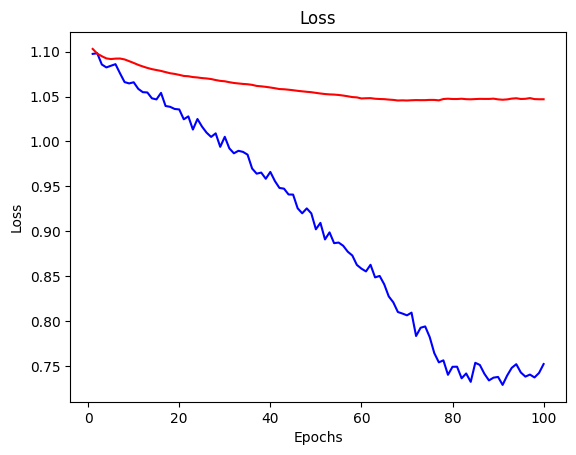

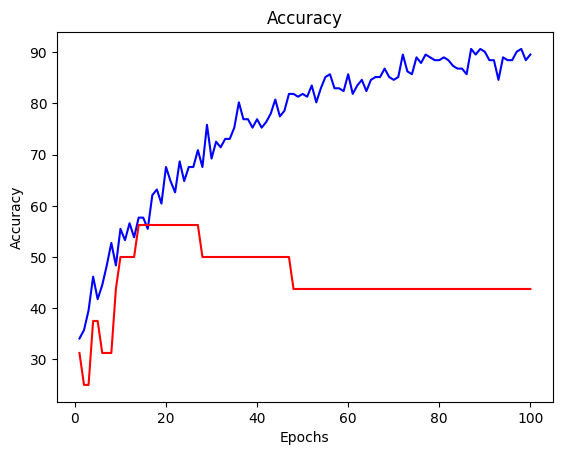

In [32]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


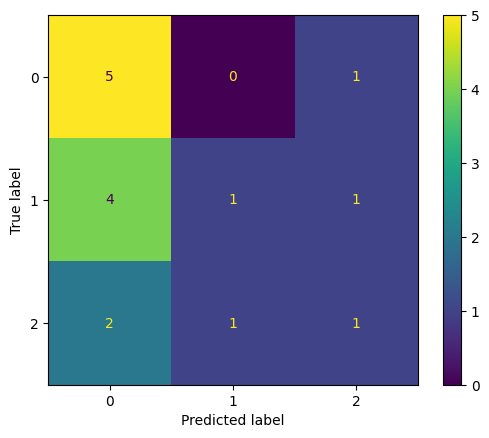

In [33]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

### ResNet50

In [34]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "hurricane_severity_res.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.1114 - accuracy: 43.41% - val_loss: 1.1514 - val_accuracy: 37.50% - time: 5.38s
Epoch 2/100 - loss: 1.0083 - accuracy: 54.40% - val_loss: 1.1247 - val_accuracy: 43.75% - time: 5.20s
Epoch 3/100 - loss: 0.9246 - accuracy: 62.09% - val_loss: 1.0978 - val_accuracy: 43.75% - time: 5.11s
Epoch 4/100 - loss: 0.8530 - accuracy: 69.78% - val_loss: 1.0814 - val_accuracy: 43.75% - time: 5.03s
Epoch 5/100 - loss: 0.7812 - accuracy: 78.02% - val_loss: 1.0702 - val_accuracy: 43.75% - time: 5.11s
Epoch 6/100 - loss: 0.7223 - accuracy: 83.52% - val_loss: 1.0610 - val_accuracy: 43.75% - time: 5.09s
Epoch 7/100 - loss: 0.6602 - accuracy: 92.31% - val_loss: 1.0547 - val_accuracy: 43.75% - time: 5.09s
Epoch 8/100 - loss: 0.6042 - accuracy: 97.25% - val_loss: 1.0509 - val_accuracy: 43.75% - time: 5.09s
Epoch 9/100 - loss: 0.5475 - accuracy: 97.25% - val_loss: 1.0472 - val_accuracy: 43.75% - time: 5.13s
Epoch 10/100 - loss: 0.5042 - accuracy: 99.45% - val_loss: 1.0449 - val_accuracy: 

In [35]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 50.00%
F1-Score : 47.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.83      0.62         6
           1       0.40      0.33      0.36         6
           2       1.00      0.25      0.40         4

    accuracy                           0.50        16
   macro avg       0.63      0.47      0.46        16
weighted avg       0.59      0.50      0.47        16



#### Visualization

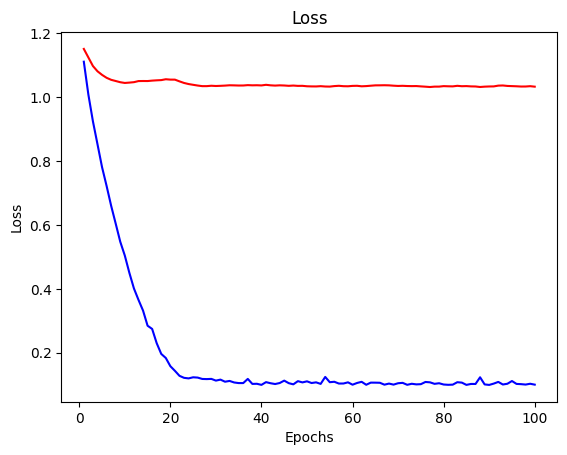

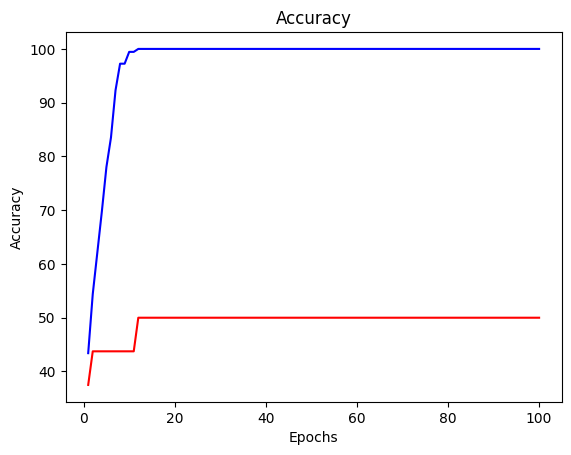

In [36]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


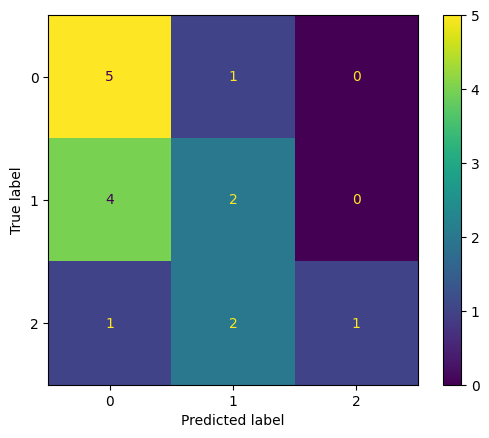

In [37]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

## Landslide

### Data Loading

In [40]:
# Landslide
train_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_landslide_train.csv'
test_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_landslide_test.csv'
# dev_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_landslide_dev.csv'

train_label = pd.read_csv(train_path)
test_label = pd.read_csv(test_path)
# dev_label = pd.read_csv(dev_path)

print(train_label.shape)
print(test_label.shape)
# print(dev_label.shape)

(28, 4)
(1, 4)


In [41]:
class_label_map = {"severe": 2, "mild": 1, "little_or_none": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label_damage_severity']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('C:/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.convert("RGB")
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

100%|██████████| 28/28 [00:00<00:00, 61.27it/s]


torch.Size([3, 256, 256])
(28, 3, 256, 256)


100%|██████████| 28/28 [00:00<?, ?it/s]


(28,)


100%|██████████| 1/1 [00:00<00:00, 83.34it/s]


torch.Size([3, 256, 256])
(1, 3, 256, 256)


100%|██████████| 1/1 [00:00<?, ?it/s]


(1,)


100%|██████████| 3/3 [00:00<00:00, 56.60it/s]


torch.Size([3, 256, 256])
(3, 3, 256, 256)


100%|██████████| 3/3 [00:00<?, ?it/s]

(3,)


In [42]:
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)

print("Number of unique classes:", num_classes)
print("Unique classes:", unique_classes)

Number of unique classes: 3
Unique classes: [0 1 2]


In [43]:
batch_size = 64

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

### EfficientNet

In [44]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "landslide_severity_eff.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.1099 - accuracy: 39.29% - val_loss: 1.1196 - val_accuracy: 0.00% - time: 4.78s
Epoch 2/100 - loss: 1.1012 - accuracy: 32.14% - val_loss: 1.1109 - val_accuracy: 0.00% - time: 4.59s
Epoch 3/100 - loss: 1.0859 - accuracy: 42.86% - val_loss: 1.1064 - val_accuracy: 0.00% - time: 4.55s
Epoch 4/100 - loss: 1.0900 - accuracy: 39.29% - val_loss: 1.1038 - val_accuracy: 0.00% - time: 4.31s
Epoch 5/100 - loss: 1.0959 - accuracy: 32.14% - val_loss: 1.1040 - val_accuracy: 0.00% - time: 4.29s
Epoch 6/100 - loss: 1.0741 - accuracy: 39.29% - val_loss: 1.1048 - val_accuracy: 0.00% - time: 4.24s
Epoch 7/100 - loss: 1.0686 - accuracy: 53.57% - val_loss: 1.1053 - val_accuracy: 0.00% - time: 4.40s
Epoch 8/100 - loss: 1.0749 - accuracy: 50.00% - val_loss: 1.1063 - val_accuracy: 0.00% - time: 4.44s
Epoch 9/100 - loss: 1.0719 - accuracy: 35.71% - val_loss: 1.1061 - val_accuracy: 0.00% - time: 4.12s
Epoch 10/100 - loss: 1.0605 - accuracy: 50.00% - val_loss: 1.1045 - val_accuracy: 0.00% - t

KeyboardInterrupt: 

In [ ]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

#### Visualization

In [ ]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

### ResNet50

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "landslide_severity_res.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

In [ ]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

#### Visualization

In [ ]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

## Not Disaster

### Data Loading

In [45]:
# Not Disaster
train_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_not_disaster_train.csv'
test_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_not_disaster_test.csv'
dev_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_not_disaster_dev.csv'

train_label = pd.read_csv(train_path)
test_label = pd.read_csv(test_path)
dev_label = pd.read_csv(dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(1578, 4)
(113, 4)
(25, 4)


In [46]:
class_label_map = {"severe": 2, "mild": 1, "little_or_none": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label_damage_severity']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('C:/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.convert("RGB")
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

100%|██████████| 1578/1578 [00:31<00:00, 50.36it/s]


torch.Size([3, 256, 256])
(1578, 3, 256, 256)


100%|██████████| 1578/1578 [00:00<00:00, 315698.15it/s]


(1578,)


100%|██████████| 113/113 [00:02<00:00, 39.33it/s]


torch.Size([3, 256, 256])
(113, 3, 256, 256)


100%|██████████| 113/113 [00:00<00:00, 112981.25it/s]


(113,)


100%|██████████| 25/25 [00:00<00:00, 33.60it/s]


torch.Size([3, 256, 256])
(25, 3, 256, 256)


100%|██████████| 25/25 [00:00<?, ?it/s]

(25,)


In [47]:
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)

print("Number of unique classes:", num_classes)
print("Unique classes:", unique_classes)

Number of unique classes: 1
Unique classes: [0]


In [48]:
batch_size = 64

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

### EfficientNet

In [49]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "notdisaster_severity_eff.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.0407 - accuracy: 62.04% - val_loss: 0.9970 - val_accuracy: 84.96% - time: 15.04s
Epoch 2/100 - loss: 0.9822 - accuracy: 83.52% - val_loss: 0.9398 - val_accuracy: 97.35% - time: 13.95s
Epoch 3/100 - loss: 0.9195 - accuracy: 94.99% - val_loss: 0.8697 - val_accuracy: 99.12% - time: 13.33s
Epoch 4/100 - loss: 0.8463 - accuracy: 99.18% - val_loss: 0.7936 - val_accuracy: 100.00% - time: 13.28s
Epoch 5/100 - loss: 0.7683 - accuracy: 99.87% - val_loss: 0.7076 - val_accuracy: 100.00% - time: 13.70s
Epoch 6/100 - loss: 0.6881 - accuracy: 100.00% - val_loss: 0.6195 - val_accuracy: 100.00% - time: 13.38s
Epoch 7/100 - loss: 0.5981 - accuracy: 100.00% - val_loss: 0.5276 - val_accuracy: 100.00% - time: 13.35s
Epoch 8/100 - loss: 0.5164 - accuracy: 100.00% - val_loss: 0.4467 - val_accuracy: 100.00% - time: 13.15s
Epoch 9/100 - loss: 0.4417 - accuracy: 100.00% - val_loss: 0.3717 - val_accuracy: 100.00% - time: 13.12s
Epoch 10/100 - loss: 0.3706 - accuracy: 100.00% - val_loss: 0.3

In [50]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 100.00%
F1-Score : 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



#### Visualization

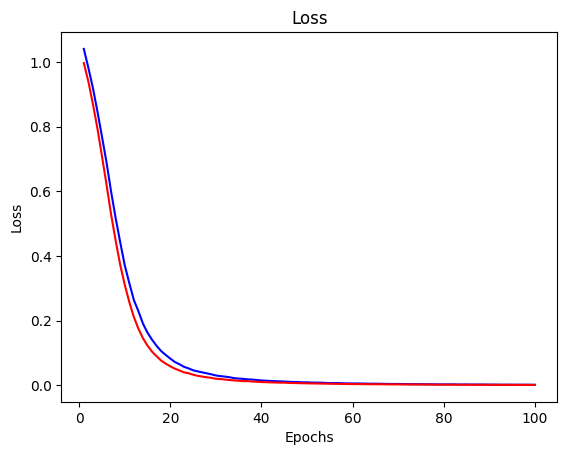

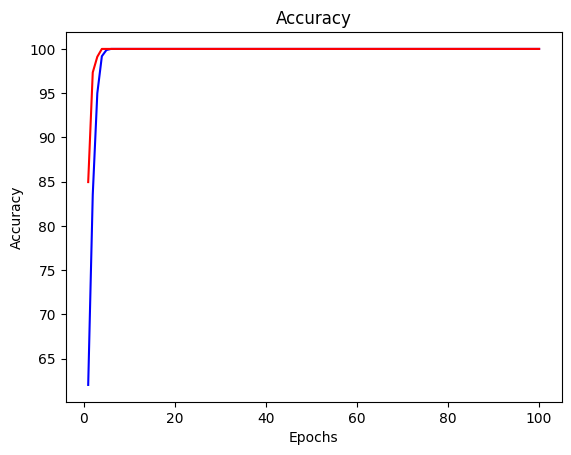

In [51]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


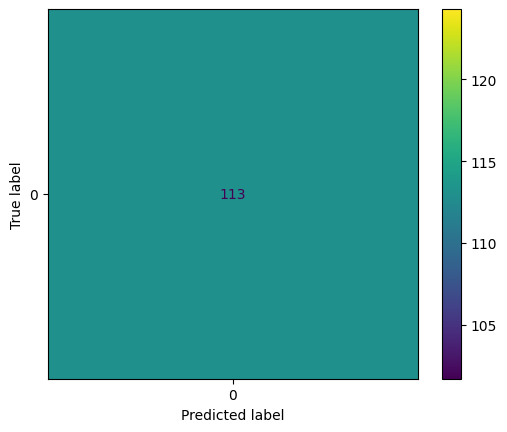

In [52]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

### ResNet50

In [53]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "notdisaster_severity_res.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.0184 - accuracy: 54.50% - val_loss: 0.7664 - val_accuracy: 94.69% - time: 15.62s
Epoch 2/100 - loss: 0.6084 - accuracy: 99.30% - val_loss: 0.3905 - val_accuracy: 100.00% - time: 15.54s
Epoch 3/100 - loss: 0.3322 - accuracy: 100.00% - val_loss: 0.2034 - val_accuracy: 100.00% - time: 15.67s
Epoch 4/100 - loss: 0.1791 - accuracy: 100.00% - val_loss: 0.1156 - val_accuracy: 100.00% - time: 15.45s
Epoch 5/100 - loss: 0.1029 - accuracy: 100.00% - val_loss: 0.0722 - val_accuracy: 100.00% - time: 15.47s
Epoch 6/100 - loss: 0.0649 - accuracy: 100.00% - val_loss: 0.0493 - val_accuracy: 100.00% - time: 15.56s
Epoch 7/100 - loss: 0.0442 - accuracy: 100.00% - val_loss: 0.0353 - val_accuracy: 100.00% - time: 15.49s
Epoch 8/100 - loss: 0.0318 - accuracy: 100.00% - val_loss: 0.0264 - val_accuracy: 100.00% - time: 15.58s
Epoch 9/100 - loss: 0.0237 - accuracy: 100.00% - val_loss: 0.0203 - val_accuracy: 100.00% - time: 15.77s
Epoch 10/100 - loss: 0.0183 - accuracy: 100.00% - val_loss

In [54]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 100.00%
F1-Score : 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



#### Visualization

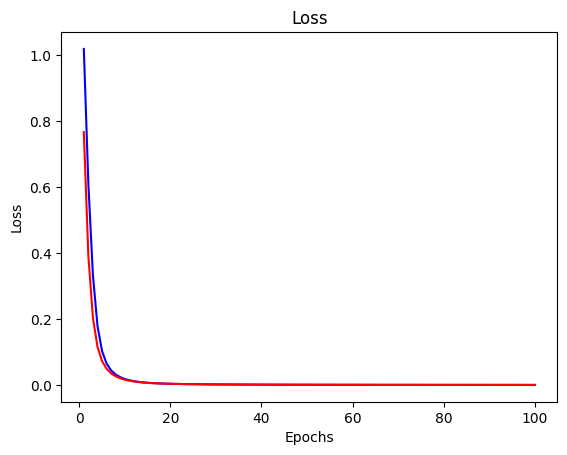

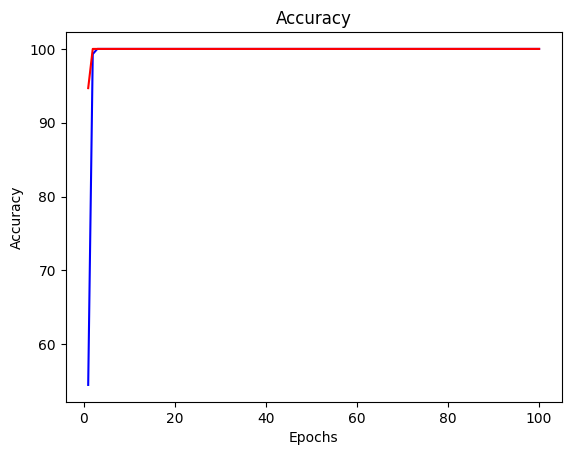

In [55]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


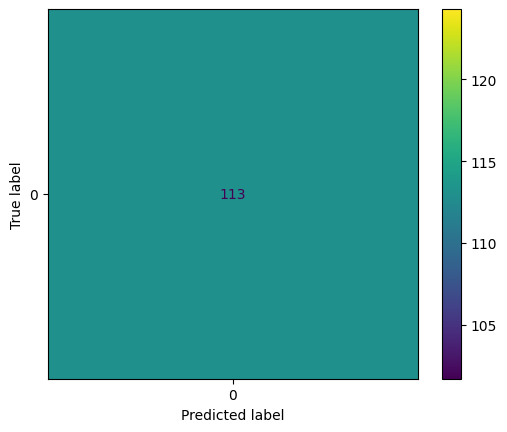

In [56]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

## Other Disaster

### Data Loading

In [57]:
# Other Disaster
train_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_other_disaster_train.csv'
test_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_other_disaster_test.csv'
dev_path = 'C:/crisis_vision_benchmarks/Reproduce/Classified by Disaster Types/class_other_disaster_dev.csv'

train_label = pd.read_csv(train_path)
test_label = pd.read_csv(test_path)
dev_label = pd.read_csv(dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(760, 4)
(52, 4)
(16, 4)


In [58]:
class_label_map = {"severe": 2, "mild": 1, "little_or_none": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label_damage_severity']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('C:/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.convert("RGB")
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

100%|██████████| 760/760 [00:10<00:00, 72.85it/s]


torch.Size([3, 256, 256])
(760, 3, 256, 256)


100%|██████████| 760/760 [00:00<00:00, 379891.67it/s]


(760,)


100%|██████████| 52/52 [00:00<00:00, 63.65it/s]


torch.Size([3, 256, 256])
(52, 3, 256, 256)


100%|██████████| 52/52 [00:00<?, ?it/s]


(52,)


100%|██████████| 16/16 [00:00<00:00, 72.40it/s]


torch.Size([3, 256, 256])
(16, 3, 256, 256)


100%|██████████| 16/16 [00:00<?, ?it/s]

(16,)


In [59]:
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)

print("Number of unique classes:", num_classes)
print("Unique classes:", unique_classes)

Number of unique classes: 3
Unique classes: [0 1 2]


In [60]:
batch_size = 64

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

### EfficientNet

In [61]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "otherdisaster_severity_eff.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.1013 - accuracy: 33.03% - val_loss: 1.0984 - val_accuracy: 30.77% - time: 8.78s
Epoch 2/100 - loss: 1.0890 - accuracy: 39.87% - val_loss: 1.0920 - val_accuracy: 40.38% - time: 8.32s
Epoch 3/100 - loss: 1.0783 - accuracy: 43.95% - val_loss: 1.0832 - val_accuracy: 46.15% - time: 8.28s
Epoch 4/100 - loss: 1.0746 - accuracy: 45.13% - val_loss: 1.0748 - val_accuracy: 48.08% - time: 8.21s
Epoch 5/100 - loss: 1.0662 - accuracy: 49.34% - val_loss: 1.0656 - val_accuracy: 51.92% - time: 8.35s
Epoch 6/100 - loss: 1.0523 - accuracy: 55.79% - val_loss: 1.0563 - val_accuracy: 53.85% - time: 8.22s
Epoch 7/100 - loss: 1.0490 - accuracy: 55.39% - val_loss: 1.0481 - val_accuracy: 57.69% - time: 8.24s
Epoch 8/100 - loss: 1.0367 - accuracy: 56.18% - val_loss: 1.0377 - val_accuracy: 61.54% - time: 8.12s
Epoch 9/100 - loss: 1.0268 - accuracy: 60.00% - val_loss: 1.0284 - val_accuracy: 69.23% - time: 8.27s
Epoch 10/100 - loss: 1.0189 - accuracy: 60.53% - val_loss: 1.0186 - val_accuracy: 

In [62]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 75.00%
F1-Score : 69.59%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80        23
           1       0.00      0.00      0.00         7
           2       0.71      0.68      0.70        22

    accuracy                           0.67        52
   macro avg       0.49      0.52      0.50        52
weighted avg       0.63      0.67      0.65        52



#### Visualization

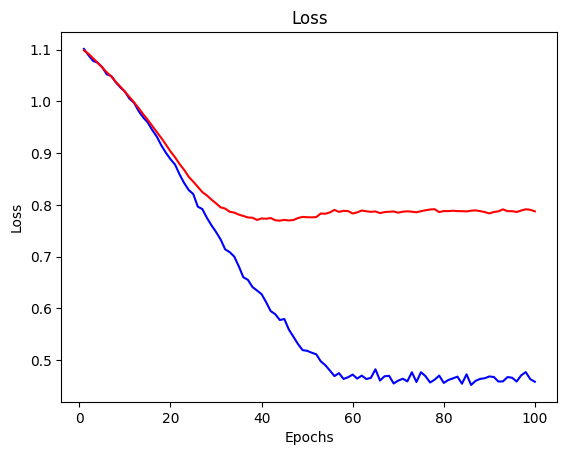

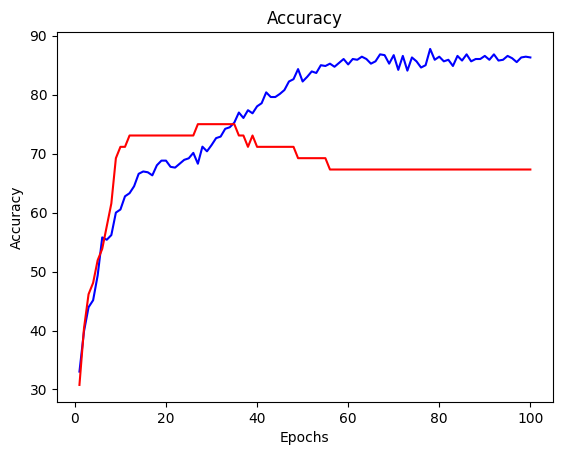

In [63]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


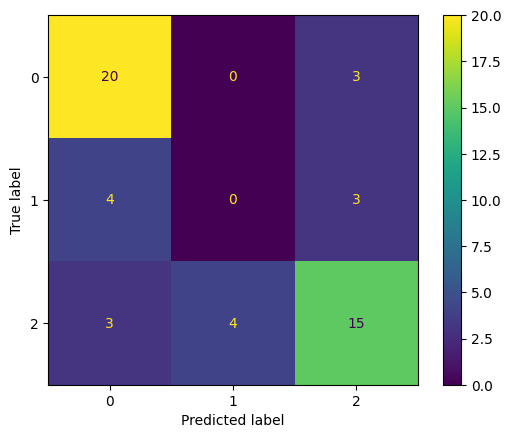

In [64]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

### ResNet50

In [65]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "f1-score": [], "time": []}

def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cm = confusion_matrix(trues, prediction)
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "otherdisaster_severity_res.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

best_val_acc = 0
best_val_f1 = 0
epochs = 100

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) 
    # dev_loss, dev_acc = dev_one_epoch(devloader) 
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) 
    
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.0520 - accuracy: 45.26% - val_loss: 0.9653 - val_accuracy: 59.62% - time: 9.86s
Epoch 2/100 - loss: 0.9048 - accuracy: 64.21% - val_loss: 0.8658 - val_accuracy: 75.00% - time: 9.73s
Epoch 3/100 - loss: 0.7890 - accuracy: 70.92% - val_loss: 0.8186 - val_accuracy: 75.00% - time: 9.59s
Epoch 4/100 - loss: 0.6926 - accuracy: 77.24% - val_loss: 0.7936 - val_accuracy: 73.08% - time: 9.65s
Epoch 5/100 - loss: 0.6003 - accuracy: 82.37% - val_loss: 0.7716 - val_accuracy: 75.00% - time: 10.14s
Epoch 6/100 - loss: 0.5068 - accuracy: 90.00% - val_loss: 0.7544 - val_accuracy: 75.00% - time: 9.03s
Epoch 7/100 - loss: 0.4129 - accuracy: 93.16% - val_loss: 0.7459 - val_accuracy: 75.00% - time: 9.23s
Epoch 8/100 - loss: 0.3313 - accuracy: 96.58% - val_loss: 0.7237 - val_accuracy: 75.00% - time: 9.24s
Epoch 9/100 - loss: 0.2724 - accuracy: 98.16% - val_loss: 0.7143 - val_accuracy: 73.08% - time: 9.36s
Epoch 10/100 - loss: 0.1946 - accuracy: 99.47% - val_loss: 0.7067 - val_accuracy:

In [66]:
print('Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print('Classification Report:')
print(cr)

Performance:
Accuracy : 76.92%
F1-Score : 73.70%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.87      0.78        23
           1       1.00      0.14      0.25         7
           2       0.78      0.82      0.80        22

    accuracy                           0.75        52
   macro avg       0.83      0.61      0.61        52
weighted avg       0.78      0.75      0.72        52



#### Visualization

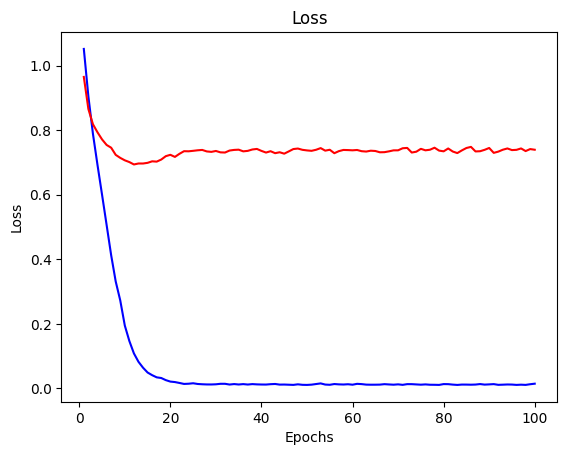

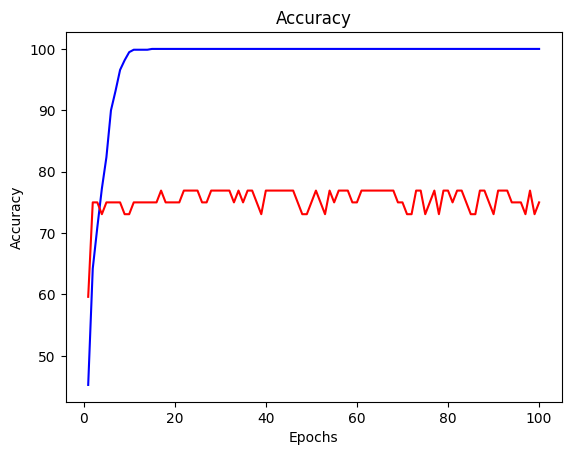

In [67]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


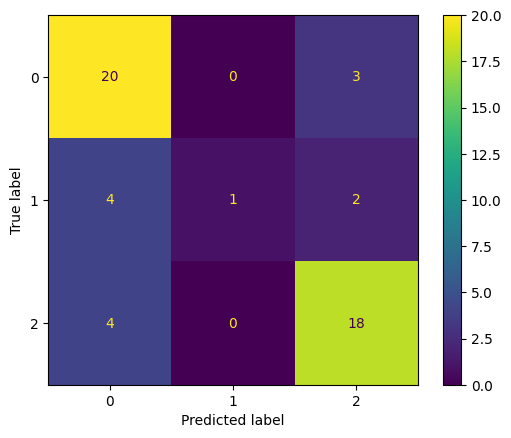

In [68]:
print('Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()